## Softmax回归用于分类问题
我们只对样本的“硬性”类别感兴趣，即属于哪个类别；我们希望得到“软性”类别，即得到属于每个类别的概率。 这两者的界限往往很模糊。其中的一个原因是：即使我们只关心硬类别，我们仍然需要使用软类别的模型（通过预测样本属于每个类别的概率，来判断其硬类别）
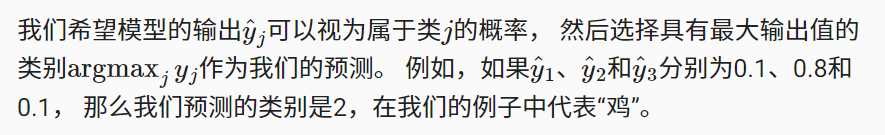

然而我们能否将未经softmax规范化的预测 o 直接视作我们感兴趣的输出呢？答案是否定的。 因为将线性层的输出直接视为概率时存在一些问题： 一方面，我们没有限制这些输出数字的总和为1。 另一方面，根据输入的不同，它们可以为负值。 这些违反了概率基本公理。

softmax运算不会改变未规范化的预测o之间的大小次序，只会确定分配给每个类别的概率。
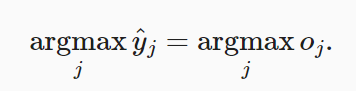

## softmax回归的网络架构
为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型（线性回归是回归问题只有一个输出，softmax回归是分类问题，有k个输出），每个类别对应一个输出结点。 与线性回归一样，softmax回归也是一个单层神经网络。

全连接层的参数尺寸：权重矩阵（输入特征维度 x 输出结点个数），偏执向量维度 = 输出结点个数
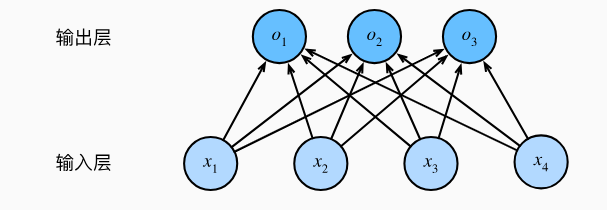

## 损失函数
分类问题常用的损失函数：交叉熵损失
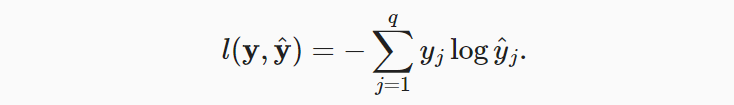
由于y是一个长度为k的独热编码向量， 所以除了一个项以外的所有项都消失了。

## 小结
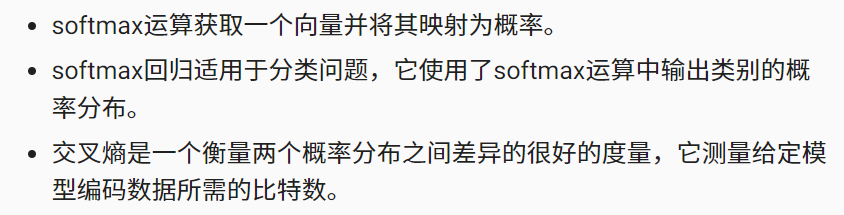

In [1]:
import torch
import torchvision
from IPython import display
from d2l import torch as d2l
from torch.utils import data
from torchvision import transforms
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

## 加载数据集

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.6%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



119.3%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw




C:\Users\ylc\.conda\envs\pytorch-GPU\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 初始化模型参数

In [3]:
# 图片张量的shape [1,28,28]，暂时把每个像素位置看作一个特征，把 28 x 28的图片展平成一个784维的特征向量
# 数据集有10个分类，即模型输出是个10维的向量
# 权重矩阵视为 784 x 10， 偏置向量视为 10 维行向量
# 使用正态分布初始化权重W，偏置b初始化为0
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01,size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义Softmax操作

In [7]:
# softmax就是把所有输入拉到[0,1]的范围内，且行和为1
def softmax(X):
    # 将矩阵中所有元素求指数幂
    X_exp = torch.exp(X)
    # 求出每行的规范化常数，留着作分母
    partition = X_exp.sum(axis=1, keepdim=True)
    # 利用广播机制得出经过softmax操作后的矩阵
    return X_exp / partition

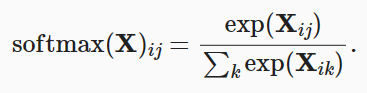

经过softmax后不会改变样本中各元素谁大谁小，softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质。

In [8]:
# 测试Softmax操作
X = torch.normal(0, 1, (2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1,keepdim=True)

tensor([[-0.1406, -0.6192,  0.8444, -0.5510, -0.1027],
        [-0.4044,  0.1803, -0.3334,  1.8400,  0.2049]])


(tensor([[0.1667, 0.1033, 0.4463, 0.1106, 0.1731],
         [0.0660, 0.1185, 0.0709, 0.6231, 0.1215]]),
 tensor([[1.0000],
         [1.0000]]))

## 定义模型：Softmax回归模型

In [8]:
def net(X):
    # 将全连接层的输出进行一次softmax操作
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 定义损失函数：交叉熵
交叉熵损失是深度学习中最常见的损失函数，常用于分类问题

In [9]:
# 交叉熵需要使用 
# 1、样本真实标签（训练集和测试集均已知）
# 2、对真实标签预测的概率（通过下面的写法可从预测结果中快速获得对样本所属真实类别预测的概率）

y = torch.tensor([0, 2]) # 真实类别标签
y_hat = torch.tensor([[0.1, 0.3, 0.6],  # 第0列意味着该样本属于第0个类别的概率
                      [0.3, 0.2, 0.5]])
y_hat[range(len(y_hat)), y] # 每个样本所属真实类别的概率

tensor([0.1000, 0.5000])

In [10]:
def cross_entropy(y_hat, y): # y_hat是预测值，y是真实类别索引
    # 写法很简单，由于分类标签为独热编码,每个样本只有一项非0，所属类别真实概率肯定是100% （即yj=1），即只有一项 -log(对真实标签预测的概率)
    # 由于公式中yj是一个长度为q的独热编码向量， 所以除了对真实类别预测的概率那一项以外的所有项都消失了。
    return - torch.log(y_hat[range(len(y_hat)), y])

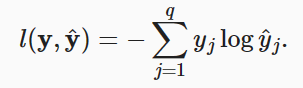

In [11]:
# 测试交叉熵损失
cross_entropy(y_hat, y) # 即使预测对了，但预测概率不够大也会有相应惩罚（有loss）

tensor([2.3026, 0.6931])

## 分类精度

In [12]:
def accuracy(y_hat, y):  
    """计算分类正确的数量(不是返回的精度)"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # argmax返回指定维度中最大值的索引，预测的样本类别索引！！
    
    cmp = y_hat.type(y.dtype) == y # 预测标签与真实标签作比较，非0即1，求和即可得出预测正确的样本个数
    return float(cmp.type(y.dtype).sum())

分类精度 = 分类正确的个数 / 进行分类的总次数

In [13]:
accuracy(y_hat, y) / len(y)  

0.5

In [14]:
def evaluate_accuracy(net, data_iter): 
    """评估模型在指定数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式（对Dropout层、BatchNorm层有用）
        
    metric = Accumulator(2)  # 正确预测数、预测样本总数
    with torch.no_grad():  
        for X, y in data_iter:
            # 记录预测正确的样本数、以及样本总数
            metric.add(accuracy(net(X), y), y.numel()) 
            
    return metric[0] / metric[1] # 计算精度

# 累加器类：用一个数组记录
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n # 生成n个元素的列表初始值都是0.0

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx): # 实现这个函数能够对他的对象像数组一样用 data[index]
        return self.data[idx]

In [15]:
# 测试一下精度计算
evaluate_accuracy(net, test_iter)

0.0719

## 训练

In [16]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """
    进行一个epoch的训练
    返回训练平均损失、训练精度
    
    """
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train() #开启训练模式
    # 累计：训练损失总和、训练准确度总和、总样本数
    metric = Accumulator(3)
    
    for X, y in train_iter:
        # 预测值可以用来算损失以及精度
        y_hat = net(X) 
        l = loss(y_hat, y) # 计算损失(reduction设置成none)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数计算梯度并更新参数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用自定义的优化器和损失函数
            # 由于自定义的sgd中除了batch_size，所以用l.sum()
            l.sum().backward()
            updater(X.shape[0])
        # 每批的训练损失之和、分类正确个数、样本数全部累加起来
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        
    # 返回平均损失和精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
# 定义一个在动画中绘制数据的实用程序类Animator
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
# 进行num_epochs个epoch，利用训练集调整模型参数，利用测试集对模型进行评估，使用Animator类可视化进度
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """训练模型"""
    # 动画展示部分
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    # 训练num_epochs个迭代周期
    for epoch in range(num_epochs):
        # 通过训练集优化模型参数
        # ----------train----------
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater) 
        
        # 评估在测试集上的精度
        # ----------valid----------
        test_acc = evaluate_accuracy(net, test_iter) 
        animator.add(epoch + 1, train_metrics + (test_acc,))
    
    train_loss, train_acc = train_metrics
    
    print(f'训练精度:{train_acc}, 测试精度:{test_acc}')
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [19]:
lr = 0.1 # 学习率（超参数）

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

训练精度:0.8479, 测试精度:0.8153


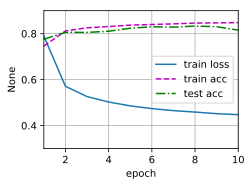

In [20]:
num_epochs = 10 # 迭代周期（是一个超参数）
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

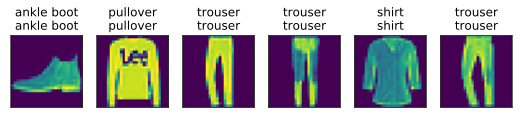

In [21]:
# 现在训练已经完成，我们的模型已经准备好对图像进行分类预测
def predict_ch3(net, test_iter, n=6): 
    """预测图片对应的标签"""
    for X, y in test_iter:
        break
    # 第一个batch的真实类别名
    trues = d2l.get_fashion_mnist_labels(y)
    # 第一个batch预测的类别名
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## 小结
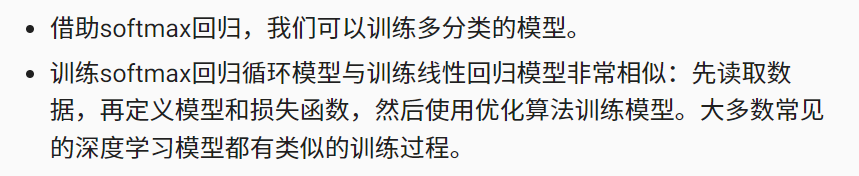